# DTSA 5511 Final Project

## Project Overview

This project utilizes deep learning techniques to identify metastatic cancer in small image patches taken from larger digital pathology scans. This is a revolutionary application of deep learning that has the potential to diagnose diseases in the early stages, which can save countless lives. Convolutional Neural Networks (CNNs) are a type of deep learning architecture that has shown significant success in image analysis. CNNs can learn to automatically extract features from the images and make predictions based on those features. Therefore, it is the ideal model choice for this use case.

In [2]:
# import libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

from skimage import io
import shutil
import os

import warnings
warnings.filterwarnings("ignore")

## Step 1: Collect Data

The data used for this project was collected from Kaggle (https://www.kaggle.com/competitions/histopathologic-cancer-detection/data) and contains small pathology images to classify. In total, the training data contains roughly 220k images and their respective labels, and the test data contains 57.5k unlabeled images.

In [3]:
# read training data with labels
df = pd.read_csv("/Users/colincunningham/Documents/MSDS/Intro to Deep Learning/histopathologic-cancer-detection/train_labels.csv")
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## Step 2: Exploratory Data Analysis (EDA)

Below, I conducted some initial exploratory analysis to familiarize myself with the dataset. As you can see the dataframe contains 220,025 rows and 2 columns (id, label). According to the Kaggle competition page, this dataset does not contain any duplicate observations or null values (confirmed below), which greatly simplifies the data cleaning process. 

In [4]:
print('Print first 5 rows:')
print(df.head())

print('\nDF info:')
df.info()

Print first 5 rows:
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

DF info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


In the cell below, I visualized the number of observations belonging to each class (no cancer vs. cancer). As you can see, the dataset is relatively balanced though there are more instances belonging to the "no cancer" class. Before constructing our models, we will need to employ sampling techniques so that the model isn't biased towards the majority class.

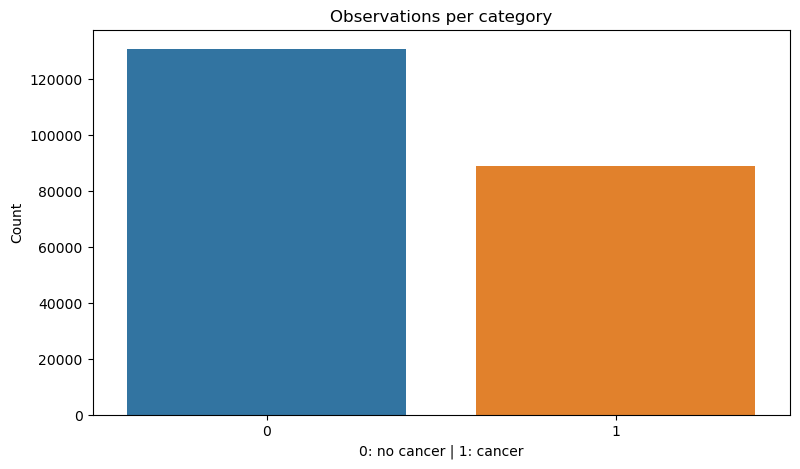

In [5]:
# create bar chart with observation counts
plt.figure(figsize = (9,5))
plt.title('Observations per category')
gb = df.groupby('label').size().reset_index()
ax = sns.barplot(x='label', data=gb, y = 0, linewidth=2).set(ylabel="Count", xlabel = '0: no cancer | 1: cancer')
plt.show()

I continued my exploratory analysis by visualizing a sample of images from each class. As you can see below, it is very difficult for the human eye to identify metastatic cancers in these images. Therefore, a well-trained deep learning model can be utilized to support doctors in detecting these harmful cancers at an early stage.

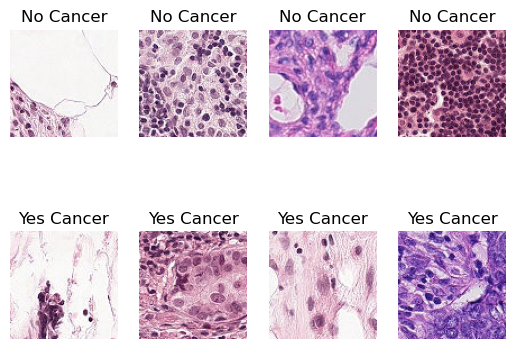

In [6]:
df["path"] = df["id"].apply(lambda x: os.path.join("/Users/colincunningham/Documents/MSDS/Intro to Deep Learning/histopathologic-cancer-detection/train", str(x) + ".tif"))
no_cancer = df[df["label"] == 0]
yes_cancer = df[df["label"] == 1]
num_images = 4

# display images without cancer
for i in range(num_images):
    im = plt.imread(no_cancer["path"].iloc[i])
    plt.subplot(2, num_images, i+1)
    plt.imshow(im)
    plt.axis('off')
    plt.title("No Cancer")

# display images with cancer
for i in range(num_images):
    im = plt.imread(yes_cancer["path"].iloc[i])
    plt.subplot(2, num_images, num_images + i + 1)
    plt.imshow(im)
    plt.axis('off')
    plt.title("Yes Cancer")

plt.show()

## Step 3: Model Architecture

#### VGGNet
VGGNET is a simple and uniform architecture that relies on stacking 3x3 convolutional filters. It is considered easy to interpret compared to other models due to its uniform architecture and generally performs very well with image classification tasks. One disadvantage associated with this architecture is that it is computationally expensive, though the dataset we are using to train the model is relatively small so its not something that to be concerned about.

#### InceptionNet
InceptionNet introduced the concept of inception modules, which use multiple filter sizes. This architecture aims to capture features at different scales and uses 1x1 convolutions for dimension reduction. While it is more computationally efficient compared to VGGNet, the complex architecture makes it model more difficult to interpret.

#### ResNet
ResNet improves on earlier deep learning techniques in that it uses residual blocks with shortcut connections, which facilitates that training of very deep neural networks. However, like InceptionNet, the skip connections introduce additional complexities which makes the model very difficult to interpret.

#### Architecture Selection
To construct my model, I decided to utilize a VGGNet architecture. Though InceptionNet and ResNet may offer greater performance, I chose VGGNET due its interpretability. I believe model explainability is crucial, especially in the medical field where the output can save/cost lives. Furthermore, I didn't put an emphasis on computational efficiency due to the relative small dataset used in this analysis.

## Step 4: Results & Analysis

In the cells below, I began the pre-processing step by balancing the dataset using sampling techniques. Then, I split the original data into training and test datasets so that I could evaluate the model's performance. 

In [7]:
df["label"] = df["label"].astype(str)
df_no = df[df["label"] == "0"].sample(10000, random_state=5)
df_yes = df[df["label"] == "1"].sample(10000, random_state=5)
df_sub = pd.concat([df_no, df_yes], ignore_index=True)

train_file_paths, test_file_paths, train_labels, test_labels = train_test_split(df_sub["path"], 
                                                                                df_sub["label"], 
                                                                                test_size=0.2, 
                                                                                random_state=5)

In [8]:
# Create train directory and copy training data into it
train_dir = "train_data"

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

os.makedirs(train_dir)
os.makedirs(os.path.join(train_dir, "0"))
os.makedirs(os.path.join(train_dir, "1"))

for file_path, label in zip(train_file_paths, train_labels):
    file_name = file_path.split("/")[-1]
    if label == "0":
        shutil.copy2(file_path, os.path.join(train_dir, "0", file_name))
    else:
        shutil.copy2(file_path, os.path.join(train_dir, "1", file_name))

# Create test directory and copy test data into it
test_dir = "test_data"

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
    
os.makedirs(test_dir)
os.makedirs(os.path.join(test_dir, "0"))
os.makedirs(os.path.join(test_dir, "1"))

for file_path, label in zip(test_file_paths, test_labels):
    file_name = file_path.split("/")[-1]
    if label == "0":
        shutil.copy2(file_path, os.path.join(test_dir, "0", file_name))
    else:
        shutil.copy2(file_path, os.path.join(test_dir, "1", file_name))

Below I used Keras' ImageDataGenerator function to generate batches of tensor image data so that the images can be used in a deep learning model.

In [14]:
# generate training image data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

# generate test image data
test_datagen = ImageDataGenerator(rescale=1.0/255)

# set training image parameters
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=True,
    seed=5
)

# set test image parameters
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(96, 96),
    batch_size=32,
    class_mode="binary",
    color_mode="rgb",
    shuffle=False,
    seed=5
)

Found 16000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In the next few cells, I trained 2 Convolutional Neural Networks (CNNs) to detect the presence of cancerous tumors in the histopathologic images. Both models have the same architecture but they use a different set of hyperparameters. I chose different optimizers, learning rates, and dropout rates to test the effects on the predictive power. See below:

In [15]:
# set hyperparameters
optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001)
batch_size = 32

model1 = Sequential()

# add convolutional layer
model1.add(Conv2D(16, (3,3), activation='relu', input_shape=(96, 96, 3)))
model1.add(BatchNormalization())
model1.add(MaxPool2D(pool_size=(3,3)))

# flatten to 1D vector
model1.add(Flatten())

# add classification layers
model1.add(Dense(64, activation='sigmoid'))
model1.add(Dropout(.5))
model1.add(Dense(1, activation='sigmoid'))

In [16]:
# Compile model1
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [17]:
# train model1
train_steps=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size

# fit model1
hist1 = model1.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=test_generator,
    validation_steps=val_steps
)

Epoch 1/10
500/500 [==============================] - 23s 45ms/step - loss: 0.5800 - accuracy: 0.7196 - val_loss: 0.5268 - val_accuracy: 0.7362
Epoch 2/10
500/500 [==============================] - 23s 45ms/step - loss: 0.5239 - accuracy: 0.7556 - val_loss: 0.6856 - val_accuracy: 0.6777
Epoch 3/10
500/500 [==============================] - 23s 45ms/step - loss: 0.5145 - accuracy: 0.7594 - val_loss: 0.5171 - val_accuracy: 0.7552
Epoch 4/10
500/500 [==============================] - 23s 46ms/step - loss: 0.5043 - accuracy: 0.7688 - val_loss: 0.4809 - val_accuracy: 0.7757
Epoch 5/10
500/500 [==============================] - 23s 46ms/step - loss: 0.4970 - accuracy: 0.7729 - val_loss: 0.8160 - val_accuracy: 0.5882
Epoch 6/10
500/500 [==============================] - 23s 46ms/step - loss: 0.4928 - accuracy: 0.7716 - val_loss: 0.4793 - val_accuracy: 0.7770
Epoch 7/10
500/500 [==============================] - 23s 47ms/step - loss: 0.4914 - accuracy: 0.7782 - val_loss: 0.7560 - val_accuracy:

In [18]:
# set hyperparameters
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)
batch_size = 32

model2 = Sequential()

# add convolutional layer
model2.add(Conv2D(16, (3,3), activation='relu', input_shape=(96, 96, 3)))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(3,3)))

# flatten to 1D vector
model2.add(Flatten())

# add classification layers
model2.add(Dense(64, activation='sigmoid'))
model2.add(Dropout(.25))
model2.add(Dense(1, activation='sigmoid'))

In [19]:
# Compile model2
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# train model2
train_steps=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size

# fit model2
hist2 = model2.fit(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=10,
    validation_data=test_generator,
    validation_steps=val_steps
)

Epoch 1/10
500/500 [==============================] - 24s 48ms/step - loss: 0.6429 - accuracy: 0.6354 - val_loss: 0.6583 - val_accuracy: 0.6133
Epoch 2/10
500/500 [==============================] - 23s 47ms/step - loss: 0.6198 - accuracy: 0.6592 - val_loss: 0.6459 - val_accuracy: 0.6355
Epoch 3/10
500/500 [==============================] - 23s 47ms/step - loss: 0.6374 - accuracy: 0.6532 - val_loss: 0.6634 - val_accuracy: 0.6380
Epoch 4/10
500/500 [==============================] - 23s 47ms/step - loss: 0.6349 - accuracy: 0.6474 - val_loss: 0.6994 - val_accuracy: 0.6135
Epoch 5/10
500/500 [==============================] - 24s 48ms/step - loss: 0.6633 - accuracy: 0.6049 - val_loss: 0.6951 - val_accuracy: 0.5410
Epoch 6/10
500/500 [==============================] - 24s 49ms/step - loss: 0.6466 - accuracy: 0.6382 - val_loss: 0.7255 - val_accuracy: 0.5153
Epoch 7/10
500/500 [==============================] - 24s 49ms/step - loss: 0.6191 - accuracy: 0.6689 - val_loss: 0.8384 - val_accuracy:

Below I created plots to visualize the accuracy for both the training and validation data. As you can see, it appears that both models have similar predictive power on the validation data, though model1 achieves a higher accuracy on the training data. Therefore, I chose the first model to make predictions on the unseen test data (see below).

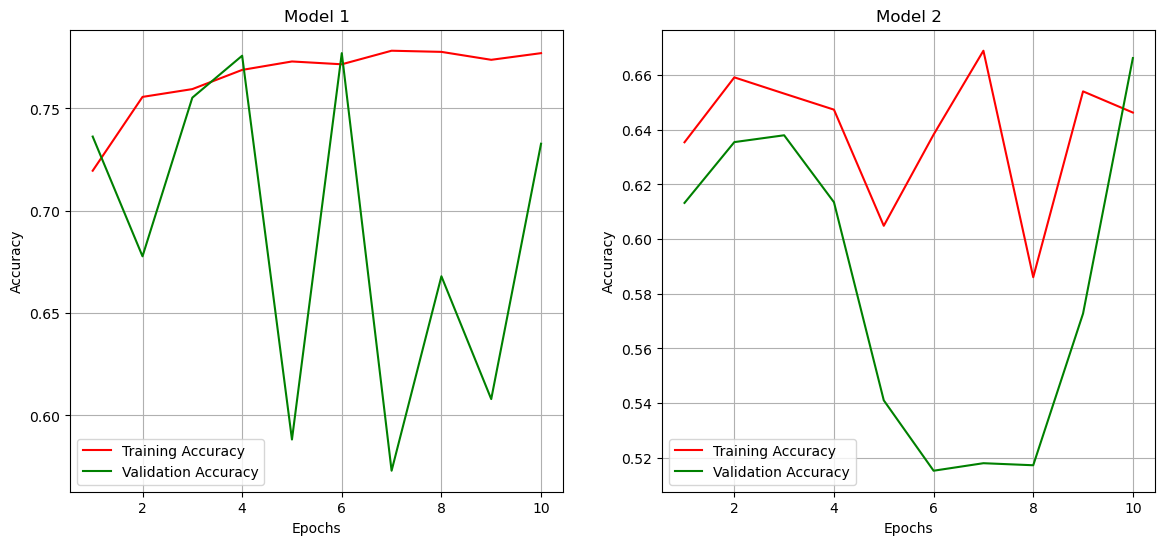

In [21]:
# get training/validation history for both models
train_acc1 = model1.history.history['accuracy']
val_acc1 = model1.history.history['val_accuracy']
train_acc2 = model2.history.history['accuracy']
val_acc2 = model2.history.history['val_accuracy']

# create array for x-axis
epochs = range(1, len(train_acc1) + 1)

# create plot for model 1
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc1, label='Training Accuracy', color='red')
plt.plot(epochs, val_acc1, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model 1')
plt.grid(True)

# create plot for model 2
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc2, label='Training Accuracy', color='red')
plt.plot(epochs, val_acc2, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model 2')
plt.grid(True)

plt.show()

Here, I created a new dataframe that contains the predictions on the unseen test data. Then, I converted the pandas DF (sub_df) to a CSV file so that it could be submitted to the Kaggle competition.

In [22]:
sub_df = pd.DataFrame(columns=["id", "label", "prediction"])

test_paths = []
for root, _, files in os.walk("/Users/colincunningham/Documents/MSDS/Intro to Deep Learning/histopathologic-cancer-detection/test"):
    for name in files:
        test_paths.append(os.path.join(root, name))

for i in range(len(test_paths)):
    image = io.imread(test_paths[i])
    id = test_paths[i].split("/")[-1].split(".")[0]
    pred = model1.predict(image.reshape(1, 96, 96, 3), verbose=0)
    
    row = {"id": id, "prediction": pred[0], "label": 0 if pred[0] < 0.5 else 1}
    sub_df.loc[len(sub_df) + 1] = row
    print(f"Progress: {len(sub_df)}/{len(test_paths)}", end="\r")

In [235]:
# download DF as csv
sub_df.to_csv("cancer_detection_submission.csv", index=False)

## Step 5: Conclusion

In conclusion, both models performed in a similar fashion, with model 1 slightly edging out model 2 in terms of the accuracy score on unseen test data. After evaluating and optimizing our final model, I was able to achieve an accuracy score of 0.78% on the training data and 0.74% on the validation data. While the model performs well, there is room for potential enhancements. A further analysis could explore more complex architectures, ensemble methods, and/or different hyperparameters to improve the performance.

Additionally, I believe that there are other evaluation metrics such as Recall that should be considered before deploying a predictive model in this setting. Recall, which measures the proportion of actual positives might be a better indicator since it will penalize the model for not recognizing true instances of cancer. If the model were to miscategorize cancerous tissue as benign, it could have very dire consequences for patients whose lives might be endangered.

## Github Repo

Visit the link below to see the full Github repository:

https://github.com/colincunningham-cu/dtsa_5511_cancer_detection